# Capstone Project - The Battle of the Neighborhoods

## Table of contents
* [Introduction: Business Problem](#introduction)
* [Data](#data)
* [Methodology](#methodology)
* [Analysis](#analysis)
* [Results and Discussion](#results)
* [Conclusion](#conclusion)

## Introduction: Business Problem <a name="introduction"></a>

**Scenario**: You are a great data scientist with a love of beating your personal bests and currently live in Istanbul, Turkey. You receive a job offer from a significant company in Amsterdam, Netherlands. If you decide to accept the offer which is indisputable well opportunity for your career, you have to move to Amsterdam city.
<img src='ams-ist.jpg' alt='scenes of cities Amsterdam and Istanbul'></img>
In order to show your best performance, you want to keep adaptation period as short as possible. That's why you're planing to move to the neighbourhood which is similiar to your home town in terms of a venues.  

So in this capstone project we will try to find an optimal location for you. 
We will try to detect locations with turkish restaurants in vicinity. We would also prefer locations as close to your job location as possible. 
We will use our data science powers to generate a few most promising neighborhoods based on this criteria.


## Data <a name="data"></a>

Based on definition of our problem, at the end of our analysis we would have answered following questions:
* How similar are Istanbul and Amsterdam city based on venues? 
* What is the best possible neighborhoods to be moved in?

We need two datasets. Each dataset should include at least following features;
* Districts
* Neighbourhoods
* Geographical coordinates (latitude, longitude)

In the website of amsterdam municipality there is neighbourhoods dataset, we will use it for our analysis. You can reach this data set with this link <a href='https://maps.amsterdam.nl/open_geodata/?k=198'>City of Amsterdam neighbourhoods dataset</a>
Unfortunately, there is no ready-to-use dataset for the city of Istanbul. We will scrape the required fetures from websites. 

Following data sources will be needed to extract/generate the required information:
* Geographical coordinates of neighbourhoods in Istanbul will be obtained using **Google Maps API geocoding** 
* Number of venues and their type and location in every neighborhood will be obtained using **Foursquare API**

### Initializing required libraries

In [192]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from geopy.geocoders import Nominatim
import requests
from bs4 import BeautifulSoup
from tqdm import tqdm_notebook as tqdm # for progressbar
import matplotlib.cm as cm
import matplotlib.colors as colors

%matplotlib inline

### Amsterdam Dataset Preperation  

In [107]:
amsterdam_data = pd.read_csv('datasets/GEBIED_BUURTEN.csv', sep=';')
amsterdam_data.head()

,OBJECTNUMMER,Buurt_code,Buurt,Buurtcombinatie_code,Stadsdeel_code,Opp_m2,WKT_LNG_LAT,WKT_LAT_LNG,LNG,LAT,Unnamed: 10
0,1,F81d,Calandlaan/Lelylaan,F81,F,275360.0,"POLYGON((4.800801 52.355175,4.809055 52.356842...","POLYGON((52.355175 4.800801,52.356842 4.809055...",4.809697,52.355708,NaN
1,2,F81e,Osdorp Zuidoost,F81,F,519366.0,"POLYGON((4.818583 52.357519,4.818622 52.356295...","POLYGON((52.357519 4.818583,52.356295 4.818622...",4.811344,52.353736,NaN
2,3,F82a,Osdorp Midden Noord,F82,F,215541.0,"POLYGON((4.786657 52.362712,4.795326 52.364434...","POLYGON((52.362712 4.786657,52.364434 4.795326...",4.791792,52.362078,NaN
3,4,F82b,Osdorp Midden Zuid,F82,F,258379.0,"POLYGON((4.788293 52.359736,4.796917 52.36148,...","POLYGON((52.359736 4.788293,52.36148 4.796917,...",4.793781,52.358838,NaN
4,5,F82c,Zuidwestkwadrant Osdorp Noord,F82,F,240774.0,"POLYGON((4.790209 52.356207,4.799258 52.358027...","POLYGON((52.356207 4.790209,52.358027 4.799258...",4.795597,52.355523,NaN


City of Amsterdam has 8 districts and 481 neigbourhoods in total.

In [108]:
len(amsterdam_data['Stadsdeel_code'].unique())

8

In [109]:
amsterdam_data['Buurt'].count().sum()

481

We will get only the columns we need for our analysis.

In [110]:
needed_columns = ['Buurt', 'Stadsdeel_code', 'LNG', 'LAT']
amsterdam_df = amsterdam_data.loc[:, needed_columns]
amsterdam_df.head()

,Buurt,Stadsdeel_code,LNG,LAT
0,Calandlaan/Lelylaan,F,4.809697,52.355708
1,Osdorp Zuidoost,F,4.811344,52.353736
2,Osdorp Midden Noord,F,4.791792,52.362078
3,Osdorp Midden Zuid,F,4.793781,52.358838
4,Zuidwestkwadrant Osdorp Noord,F,4.795597,52.355523


We will add names of districts. Also we will change the names of our columns. Finally, reorder columns and amsterdam dataset is ready to use.  

In [111]:
amsterdam_districts = {'B':'Westpoort', 'T':'Zuidoost', 'M':'Oost', 'A':'Centrum', 
                       'N':'Noord', 'F':'Nieuw-West', 'E':'West', 'K':'Zuid'}
amsterdam_df.replace({'Stadsdeel_code': amsterdam_districts}, inplace=True)

proper_column_names = {'Buurt':'Neighbourhood', 'Stadsdeel_code':'District', 'LNG':'Longitude', 'LAT':'Latitude'}
amsterdam_df.rename(columns=proper_column_names, inplace=True)

column_order = ['District', 'Neighbourhood', 'Latitude', 'Longitude']
amsterdam_df = amsterdam_df[column_order]
amsterdam_df.head()

,District,Neighbourhood,Latitude,Longitude
0,Nieuw-West,Calandlaan/Lelylaan,52.355708,4.809697
1,Nieuw-West,Osdorp Zuidoost,52.353736,4.811344
2,Nieuw-West,Osdorp Midden Noord,52.362078,4.791792
3,Nieuw-West,Osdorp Midden Zuid,52.358838,4.793781
4,Nieuw-West,Zuidwestkwadrant Osdorp Noord,52.355523,4.795597


### Istanbul Dataset Preperation

In [7]:
url = "https://en.wikipedia.org/wiki/List_of_neighbourhoods_of_Istanbul"
response = requests.get(url)
document = BeautifulSoup(response.content, 'html.parser')

We get our target div element.

In [8]:
target_div = document.select('div[class="mw-parser-output"]')[0]

Istanbul city has 39 districts and 783 neighbourhoods in total.

In [9]:
len(target_div.select('h3'))

39

In [10]:
len(target_div.select('ol li'))

783

Every h3 element involves the district name and each li element in ol tags represents neighbourhoods. We wrote a function to get values from the target.

In [11]:
def get_values(target):
    column_names = ['District', 'Neighbourhood']
    df = pd.DataFrame(columns=column_names)
    ix = 0
    for h3, ol in tqdm(zip(target.select('h3'), target.select('ol'))):
        for li in ol.select('li'):
            try:
                neigh = li.a.string
            except:
                neigh = li.string
            dist = h3.select('.mw-headline')[0].string
            df.loc[ix] = [dist, neigh] 
            ix += 1
    return df

In [12]:
istanbul_data = get_values(target_div)
istanbul_data.head()

,District,Neighbourhood
0,Adalar,Burgazada
1,Adalar,Heybeliada
2,Adalar,Kınalıada
3,Adalar,Maden
4,Adalar,Nizam


Is there any Nan value in the dataframe?

In [13]:
istanbul_data.isna().any()

District         False
Neighbourhood    False
dtype: bool

When we look neighbourhood column, we see some of them involves both neighbourhood and district name with comma seperation.
We will get rid of these unnecessary district names.
Also we should remove special characters from 'District' column. Without it we may not show proper choropleth maps.

In [14]:
istanbul_data.loc[395:400]

,District,Neighbourhood
395,Fatih,"Yavuz Sultan Selim, Fatih"
396,Fatih,"Yedikule, Fatih"
397,Fatih,"Zeyrek, Fatih"
398,Gaziosmanpaşa,Bağlarbaşı
399,Gaziosmanpaşa,Barbaros Hayrettin Paşa
400,Gaziosmanpaşa,Fevzi Çakmak


In [15]:
istanbul_data.District.unique()

array(['Adalar', 'Arnavutköy', 'Ataşehir', 'Avcılar', 'Bağcılar',
       'Bahçelievler', 'Bakırköy', 'Başakşehir', 'Bayrampaşa', 'Beşiktaş',
       'Beykoz', 'Beylikdüzü', 'Beyoğlu', 'Büyükçekmece', 'Çatalca',
       'Çekmeköy', 'Esenler', 'Esenyurt', 'Eyüp', 'Fatih',
       'Gaziosmanpaşa', 'Güngören', 'Kadıköy', 'Kağıthane', 'Kartal',
       'Küçükçekmece', 'Maltepe', 'Pendik', 'Sancaktepe', 'Sarıyer',
       'Silivri', 'Sultanbeyli', 'Sultangazi', 'Şile', 'Şişli', 'Tuzla',
       'Ümraniye', 'Üsküdar', 'Zeytinburnu'], dtype=object)

In [16]:
destination = istanbul_data.loc[istanbul_data['Neighbourhood'].str.contains(','), 'Neighbourhood']
istanbul_data.loc[istanbul_data['Neighbourhood'].str.contains(','), 'Neighbourhood'] = destination.apply(lambda neigh: neigh.split(',')[0])
istanbul_districts = {'Arnavutköy':'Arnavutkoy', 'Ataşehir':'Atasehir', 'Avcılar':'Avcilar', 'Bağcılar': 'Bagcilar', 'Bahçelievler':'Bahcelievler',
                      'Bakırköy':'Bakirkoy', 'Başakşehir':'Basaksehir', 'Bayrampaşa':'Bayrampasa', 'Beşiktaş': 'Besiktas', 'Beylikdüzü':'Beylikduzu', 
                      'Beyoğlu':'Beyoglu', 'Büyükçekmece': 'Buyukcekmece', 'Çatalca':'Catalca', 'Çekmeköy':'Cekmekoy', 'Eyüp':'Eyup', 
                      'Gaziosmanpaşa':'Gaziosmanpasa', 'Güngören':'Gungoren', 'Kadıköy':'Kadikoy', 'Kağıthane':'Kagithane', 'Küçükçekmece':'Kucukcekmece', 
                      'Sarıyer':'Sariyer', 'Şile':'Sile', 'Şişli':'Sisli', 'Ümraniye':'Umraniye', 'Üsküdar':'Uskudar'}
istanbul_data.replace({'District': istanbul_districts}, inplace=True)
istanbul_data.loc[395:400]

,District,Neighbourhood
395,Fatih,Yavuz Sultan Selim
396,Fatih,Yedikule
397,Fatih,Zeyrek
398,Gaziosmanpasa,Bağlarbaşı
399,Gaziosmanpasa,Barbaros Hayrettin Paşa
400,Gaziosmanpasa,Fevzi Çakmak


Now, we should get coordinates of each neighbourhood. To do that, we will use **Google Maps API geocoding** recursively.

In [16]:
def get_coordinates(api_key, address, verbose=False):
    try:
        url = 'https://maps.googleapis.com/maps/api/geocode/json?key={}&address={}'.format(api_key, address)
        response = requests.get(url).json()
        if verbose:
            print('Google Maps API JSON result =>', response)
        results = response['results']
        geographical_data = results[0]['geometry']['location'] # get geographical coordinates
        lat = geographical_data['lat']
        lon = geographical_data['lng']
        return [lat, lon]
    except:
        return [None, None]

In [17]:
def get_all_coordinates(df, api_key):
    for index, (neigh, dist) in tqdm(enumerate(zip(df.Neighbourhood, df.District))):
        address = neigh + ', ' + dist + ', istanbul'
        lat, long = get_coordinates(api_key, address)
        df.loc[index, 'Latitude'] = lat
        df.loc[index, 'Longitude'] = long
    return df

API_KEY value was removed after getting the locations.

In [32]:
API_KEY = "???"

In [7]:
istanbul_df = get_all_coordinates(istanbul_data, API_KEY)

We will save our dataframe as csv file to make it available for later usage.

In [17]:
# istanbul_df.to_csv('datasets/istanbul.csv', index=False)
istanbul_df = pd.read_csv('datasets/istanbul.csv')

In [18]:
istanbul_df.head()

,District,Neighbourhood,Latitude,Longitude
0,Adalar,Burgazada,40.880000,29.066944
1,Adalar,Heybeliada,40.877974,29.095299
2,Adalar,Kınalıada,40.909070,29.053205
3,Adalar,Maden,40.858320,29.123072
4,Adalar,Nizam,40.863169,29.116381


Could we get all neighbourhood locations correctly? What is total number of Nan values for each column?

In [19]:
istanbul_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 783 entries, 0 to 782
Data columns (total 4 columns):
District         783 non-null object
Neighbourhood    783 non-null object
Latitude         730 non-null float64
Longitude        730 non-null float64
dtypes: float64(2), object(2)
memory usage: 24.5+ KB


In [20]:
istanbul_df.isnull().sum()

District          0
Neighbourhood     0
Latitude         53
Longitude        53
dtype: int64

We will drop the rows of the Nan value and we will continue to analysis with rest of them.

In [21]:
istanbul_df.dropna(axis=0, inplace=True)
istanbul_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 730 entries, 0 to 782
Data columns (total 4 columns):
District         730 non-null object
Neighbourhood    730 non-null object
Latitude         730 non-null float64
Longitude        730 non-null float64
dtypes: float64(2), object(2)
memory usage: 28.5+ KB


Some neighbourhoods are very close each other. That's why may be some of them have the same lat and long values. Let's examine that is there any merged neighbourhood.

In [22]:
istanbul_df[istanbul_df.duplicated(['Latitude', 'Longitude'],keep=False)].shape

(26, 4)

In [23]:
istanbul_df.drop_duplicates(subset=['Latitude', 'Longitude'], inplace=True)
istanbul_df.shape

(713, 4)

### Visualisation of Datasets

In [33]:
# lat_amsterdam, long_amsterdam = get_coordinates(API_KEY, 'Amsterdam, Netherlands')
# lat_istanbul, long_istanbul = get_coordinates(API_KEY, 'Istanbul, Turkey')
lat_amsterdam, long_amsterdam = (52.3680, 4.9036)
lat_istanbul, long_istanbul = (41.0082, 28.9784)

In [151]:
print('The geograpical coordinate of Amsterdam are {}, {}.'.format(lat_amsterdam, long_amsterdam))

The geograpical coordinate of Amsterdam are 52.368, 4.9036.


In [163]:
map_amsterdam = folium.Map(location=[lat_amsterdam, long_amsterdam], zoom_start=12)
map_amsterdam
for lat, lng, dist, neigh in zip(amsterdam_df['Latitude'], amsterdam_df['Longitude'], amsterdam_df['District'], amsterdam_df['Neighbourhood']):
    label = '{}, {}'.format(neigh, dist)
    label = folium.Popup(label, parse_html=True)
    
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='#5199FF',
        fill=True,
        fill_color='#B7D4FF',
        fill_opacity=0.6,
        parse_html=True
        ).add_to(map_amsterdam)  
    
map_amsterdam

In [153]:
print('The geograpical coordinate of Istanbul are {}, {}.'.format(lat_istanbul, long_istanbul))

The geograpical coordinate of Istanbul are 41.0082, 28.9784.


In [171]:
map_istanbul = folium.Map(location=[lat_istanbul, long_istanbul], zoom_start=11)
for lat, lng, dist, neigh in zip(istanbul_df['Latitude'], istanbul_df['Longitude'], istanbul_df['District'], istanbul_df['Neighbourhood']):
    label = '{}, {}'.format(neigh, dist)
    label = folium.Popup(label, parse_html=True)
    
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='#5199FF',
        fill=True,
        fill_color='#B7D4FF',
        fill_opacity=0.6,
        parse_html=True
        ).add_to(map_istanbul)  
    
map_istanbul

## Methodology <a name="methodology"></a>

In order to find the best solution to our business problem, we will focus on how similar the neighbourhoods are based on venues information in vicinity. 
For keeping adaptation time as short as possible, we will focus on **Turkish Restaurants** in the city of Amsterdam.

Until now, we have prepared the required datasets. But for illustration purposes, we will limit our analysis by excepting the districts which are at the very edge of each cities. 

Second step will be getting top-20 venues of each neighbourhoods via **Foursquare API**.

Next phase in our analysis will be exploration of cities individually.

In final step, we will merge two datasets into one and we will apply k-means algorithm to create **clusters of neighbourhoods**. We will take into consideration venues with **within radius of 500 meters**. 

We will present map of all clusters (using **k-means clustering**) of neighbourhoods to identify similarity.

In [112]:
excepted_districts_amsterdam = ['Zuidoost', 'Westpoort']
amsterdam_df = amsterdam_df.loc[~amsterdam_df.District.isin(excepted_districts_amsterdam)]
amsterdam_df.groupby('District').count().sum()

Neighbourhood    425
Latitude         425
Longitude        425
dtype: int64

In [25]:
excepted_districts_istanbul = ['Sile', 'Silivri', 'Catalca', 'Buyukcekmece', 'Beylikduzu', 'Arnavutkoy', 
                               'Esenyurt', 'Avcilar', 'Cekmekoy', 'Tuzla', 'Pendik', 'Sultanbeyli']
istanbul_df = istanbul_df.loc[~istanbul_df.District.isin(excepted_districts_istanbul)]
istanbul_df.groupby('District').count().sum()

Neighbourhood    522
Latitude         522
Longitude        522
dtype: int64

### Foursquare
Now that we have our coordinates of neighbourhoods, let's use Foursquare API to get top-20 venues for each.

We're interested in venues in 'Turkish Restaurants' category in Amsterdam.

First definition Foursquare Credentials and version

In [33]:
CLIENT_ID = 'KVZ4QIDBPQZZMNM5HUD4UHZEX3IQ3FIQM5P2URZQIBC2AZ5H' 
CLIENT_SECRET = '35401EZGW344DHZMX42QCF4V0MSROH104WL3UZSE2G4W4DML' 
VERSION = '20180605'

Now, creation of the function for getting nearby venues request URL.

In [40]:
def getNearbyVenues(df, rad=500, limit=50):
    venues_list=[]
    
    for dist, neigh, lat, lng in tqdm(zip(df.District, df.Neighbourhood, df.Latitude, df.Longitude)):
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            rad, 
            limit)
        response = None
        
        # make the GET request
        while response == None:
            try:
                response = requests.get(url).json()
                results = response["response"]['groups'][0]['items']
            except:
                pass
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            dist,
            neigh,
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name'],
            v['venue']['categories'][0]['id']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['District', 
                             'Neighbourhood',
                             'Neighborhood Latitude',
                             'Neighborhood Longitude', 
                             'Venue', 
                             'Venue Latitude', 
                             'Venue Longitude', 
                             'Venue Category',
                             'Venue Id']
    
    return nearby_venues

In [26]:
# amsterdam_venues = getNearbyVenues(amsterdam_df, rad=500, limit=50)
amsterdam_venues = pd.read_csv('datasets/amsterdam_venues.csv')
amsterdam_venues.head()

,District,Neighbourhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Venue Id
0,Nieuw-West,Calandlaan/Lelylaan,52.355708,4.809697,Toko Bandung,52.354358,4.810843,Indonesian Restaurant,4deefc054765f83613cdba6f
1,Nieuw-West,Calandlaan/Lelylaan,52.355708,4.809697,Enfes,52.354057,4.810545,Turkish Restaurant,4f04af1f2fb6e1c99f3db0bb
2,Nieuw-West,Calandlaan/Lelylaan,52.355708,4.809697,Sportcentrum Caland,52.354371,4.807132,Gym / Fitness Center,4bf58dd8d48988d175941735
3,Nieuw-West,Calandlaan/Lelylaan,52.355708,4.809697,De Meervaart,52.358970,4.807311,Theater,4bf58dd8d48988d137941735
4,Nieuw-West,Calandlaan/Lelylaan,52.355708,4.809697,TK Maxx,52.359155,4.805335,Clothing Store,4bf58dd8d48988d103951735


In [43]:
# amsterdam_venues.to_csv('datasets/amsterdam_venues.csv', index=False)

In [27]:
amsterdam_venues.shape

(11674, 9)

In [28]:
# istanbul_venues = getNearbyVenues(istanbul_df, rad=500, limit=50)
istanbul_venues = pd.read_csv('datasets/istanbul_venues.csv')
istanbul_venues.head()

,District,Neighbourhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Venue Id
0,Adalar,Burgazada,40.88,29.066944,Sait Faik Abasıyanık Müzesi,40.881015,29.067458,History Museum,4bf58dd8d48988d190941735
1,Adalar,Burgazada,40.88,29.066944,Adalar Cemevi Çay Bahçesi,40.879195,29.068156,Tea Room,4bf58dd8d48988d1dc931735
2,Adalar,Burgazada,40.88,29.066944,Four Letter Word,40.880573,29.068838,Café,4bf58dd8d48988d16d941735
3,Adalar,Burgazada,40.88,29.066944,Burgazada Sahil,40.881171,29.069600,Beach,4bf58dd8d48988d1e2941735
4,Adalar,Burgazada,40.88,29.066944,Sinem Dondurma,40.880984,29.069779,Ice Cream Shop,4bf58dd8d48988d1c9941735


In [29]:
istanbul_venues.to_csv('datasets/istanbul_venues.csv', index=False)

In [30]:
istanbul_venues.shape

(18870, 9)

## Analysis <a name="analysis"></a>

Let's start our analysis. First, we will make some basic explanatory data analysis for each city individually.

### City of Amsterdam
How many venues **each district of Amsterdam** has? 

In [31]:
amsterdam_venues.groupby('District').count().sort_values(by='Venue', ascending=False).reset_index()

,District,Neighbourhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Venue Id
0,Centrum,3369,3369,3369,3369,3369,3369,3369,3369
1,Zuid,2709,2709,2709,2709,2709,2709,2709,2709
2,West,2537,2537,2537,2537,2537,2537,2537,2537
3,Oost,1588,1588,1588,1588,1588,1588,1588,1588
4,Nieuw-West,873,873,873,873,873,873,873,873
5,Noord,598,598,598,598,598,598,598,598


In [34]:
map_amsterdam = folium.Map(location=[lat_amsterdam, long_amsterdam], zoom_start=12)
amsterdam_districts_geo = r'datasets/amsterdam_districts.json'
folium.Choropleth(
    geo_data=amsterdam_districts_geo,
    data=amsterdam_venues.groupby('District').count().sort_values(by='Venue', ascending=False).reset_index(),
    columns=['District', 'Venue'],
    key_on='feature.properties.Stadsdeel',
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Venue density of Amsterdam city').add_to(map_amsterdam)
map_amsterdam

How many **unique category** they have?

In [35]:
# Total unique categories number
amsterdam_venues['Venue Category'].nunique()

342

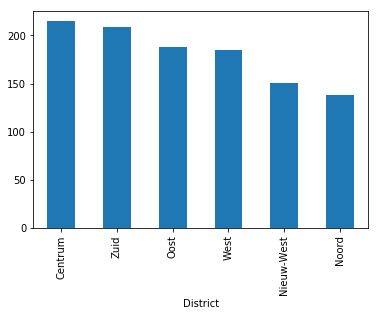

In [36]:
# Number of unique categories per district
y = amsterdam_venues.groupby('District')['Venue Category'].nunique().sort_values(ascending=False)
y.plot(kind='bar')

Is there any neighbourhood with without any venue?

In [88]:
amsterdam_venues.groupby(['District', 'Neighbourhood']).count().shape[0]

422

We know that Amsterdam city has 425 neighbourhoods, that means 3 neighbourhoods have no venues in radius 500m. Let's find them. 

In [113]:
temp_df = amsterdam_df.groupby(['District', 'Neighbourhood']).count().reset_index().loc[:, ['District', 'Neighbourhood']]
temp_df2 = amsterdam_venues.groupby(['District', 'Neighbourhood']).count().reset_index().loc[:, ['District', 'Neighbourhood']]
temp_df3 = temp_df.append(temp_df2)
temp_df3.drop_duplicates(keep=False)

,District,Neighbourhood
181,Noord,Ransdorp
214,Oost,Buiteneiland
236,Oost,Middeneiland Noordwest


If we can not get venues info from the neighbourhoods we can not cluster them. That's why we will drop these rows from our datasets.

In [114]:
neighlist = temp_df3.drop_duplicates(keep=False).Neighbourhood
amsterdam_df.loc[amsterdam_df.Neighbourhood.isin(neighlist)]

,District,Neighbourhood,Latitude,Longitude
178,Noord,Ransdorp,52.390767,5.004403
343,Oost,Middeneiland Noordwest,52.359801,5.012931
345,Oost,Buiteneiland,52.369115,5.019844


In [115]:
amsterdam_df.drop([178,343,345], inplace=True)
amsterdam_df.reset_index(drop=True, inplace=True)
amsterdam_df.shape

(422, 4)

In [39]:
amsterdam_venues_onehotted = pd.get_dummies(amsterdam_venues[['Venue Category']], prefix="", prefix_sep="")
amsterdam_venues_onehotted['District'] = amsterdam_venues['District']
amsterdam_venues_onehotted['Neighbourhood'] = amsterdam_venues['Neighbourhood']

column_order = ['District', 'Neighbourhood'] + list(amsterdam_venues_onehotted.columns[:-2])
amsterdam_venues_onehotted = amsterdam_venues_onehotted[column_order]
amsterdam_venues_onehotted.head()

,District,Neighbourhood,Accessories Store,Advertising Agency,Afghan Restaurant,African Restaurant,American Restaurant,Antique Shop,Aquarium,Arcade,...,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Whisky Bar,Wine Bar,Wine Shop,Women's Store,Yoga Studio,Zoo,Zoo Exhibit
0,Nieuw-West,Calandlaan/Lelylaan,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Nieuw-West,Calandlaan/Lelylaan,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Nieuw-West,Calandlaan/Lelylaan,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Nieuw-West,Calandlaan/Lelylaan,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Nieuw-West,Calandlaan/Lelylaan,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [40]:
amsterdam_venues_onehotted.shape

(11674, 344)

In [163]:
amsterdam_venues_grouped = amsterdam_venues_onehotted.groupby(['District', 'Neighbourhood']).mean().reset_index()
amsterdam_venues_grouped.head()

,District,Neighbourhood,Accessories Store,Advertising Agency,Afghan Restaurant,African Restaurant,American Restaurant,Antique Shop,Aquarium,Arcade,...,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Whisky Bar,Wine Bar,Wine Shop,Women's Store,Yoga Studio,Zoo,Zoo Exhibit
0,Centrum,Alexanderplein e.o.,0.0,0.0,0.00,0.02,0.0,0.0,0.02,0.0,...,0.0,0.0,0.0,0.0,0.02,0.0,0.00,0.02,0.02,0.24
1,Centrum,Amstelveldbuurt,0.0,0.0,0.00,0.00,0.0,0.0,0.00,0.0,...,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.00,0.00,0.00
2,Centrum,Anjeliersbuurt Noord,0.0,0.0,0.00,0.00,0.0,0.0,0.00,0.0,...,0.0,0.0,0.0,0.0,0.02,0.0,0.02,0.02,0.00,0.00
3,Centrum,Anjeliersbuurt Zuid,0.0,0.0,0.02,0.00,0.0,0.0,0.00,0.0,...,0.0,0.0,0.0,0.0,0.02,0.0,0.02,0.00,0.00,0.00
4,Centrum,BG-terrein e.o.,0.0,0.0,0.00,0.00,0.0,0.0,0.00,0.0,...,0.0,0.0,0.0,0.0,0.02,0.0,0.02,0.00,0.00,0.00


In [164]:
amsterdam_venues_grouped.shape

(422, 344)

Let's see what is top 10 venue categories in overall amsterdam.

In [43]:
amsterdam_overall_top_10 = amsterdam_venues_grouped.iloc[:,2:].sum().sort_values(ascending=False)[:10]
amsterdam_overall_top_10 = amsterdam_overall_top_10*100/amsterdam_overall_top_10.sum()
amsterdam_overall_top_10

Restaurant            13.356539
Bus Stop              11.194296
Coffee Shop           11.122601
Café                  10.820802
Bar                   10.689614
Hotel                 10.427713
Park                   9.134961
Supermarket            8.788215
Italian Restaurant     7.894075
Bakery                 6.571183
dtype: float64

### Istanbul city
How many venues **each district of Istanbul** has?

In [44]:
istanbul_venues.groupby('District').count().sort_values(by='Venue', ascending=False).reset_index()

,District,Neighbourhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Venue Id
0,Fatih,2647,2647,2647,2647,2647,2647,2647,2647
1,Beyoglu,1867,1867,1867,1867,1867,1867,1867,1867
2,Uskudar,1176,1176,1176,1176,1176,1176,1176,1176
3,Sisli,1132,1132,1132,1132,1132,1132,1132,1132
4,Umraniye,979,979,979,979,979,979,979,979
5,Kadikoy,863,863,863,863,863,863,863,863
6,Sariyer,841,841,841,841,841,841,841,841
7,Besiktas,724,724,724,724,724,724,724,724
8,Kagithane,687,687,687,687,687,687,687,687
9,Atasehir,645,645,645,645,645,645,645,645


In [45]:
map_istanbul = folium.Map(location=[lat_istanbul, long_istanbul], zoom_start=11)
istanbul_districts_geo = f'datasets/istanbul_districts.json'


folium.Choropleth(
    geo_data=istanbul_districts_geo,
    data=istanbul_venues.groupby('District').count().sort_values(by='Venue', ascending=False).reset_index(),
    columns=['District', 'Venue'],
    key_on='feature.properties.name_3',
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Venue density of Istanbul city').add_to(map_istanbul)
map_istanbul

Is there any neighbourhoods without any venue? But we should be carefull because there are some neighbourhoods with same name in different districts.

In [46]:
len(istanbul_venues.groupby(['District', 'Neighbourhood'])['Neighbourhood'].nunique().index.levels[1])

449

In [47]:
istanbul_venues.groupby(['District', 'Neighbourhood']).mean().reset_index().shape

(521, 6)

In [48]:
521-449 

72

As we can understand there are 72 neighbourhoods which has same name with other neighbourhoods in different district. And 521 shows us one neighbourhood has no venue. Let's find it!

In [116]:
temp_df = istanbul_venues.groupby(['District', 'Neighbourhood']).mean().reset_index()
temp_df2 = istanbul_df.groupby(['District', 'Neighbourhood']).mean().reset_index()
temp_df3 = temp_df.loc[:, ['District', 'Neighbourhood']].append(temp_df2.loc[:, ['District', 'Neighbourhood']])
temp_df3.drop_duplicates(keep=False)

,District,Neighbourhood
106,Beykoz,Yavuz Selim


Yes, we found it. In Yavuz Selim neighbourhood of Beykoz district has no venue. We will again drop this row. First we should find the index of it.

In [119]:
neigh = temp_df3.drop_duplicates(keep=False).Neighbourhood
istanbul_df.loc[istanbul_df.Neighbourhood.isin(neigh)]

,District,Neighbourhood,Latitude,Longitude
178,Beykoz,Yavuz Selim,41.073182,29.179765
299,Esenler,Yavuz Selim,41.037050,28.888078


As you see there are same neighbourhood name in different districts. We will drop at index 178. 

In [120]:
istanbul_df.drop([178], inplace=True)
istanbul_df.reset_index(drop=True, inplace=True)
istanbul_df.shape

(521, 4)

Now, we continue our analysis.

In [127]:
istanbul_venues_onehotted = pd.get_dummies(istanbul_venues[['Venue Category']], prefix="", prefix_sep="")
istanbul_venues_onehotted['District'] = istanbul_venues['District']
istanbul_venues_onehotted['Neighbourhood'] = istanbul_venues['Neighbourhood']

column_order = ['District', 'Neighbourhood'] + list(istanbul_venues_onehotted.columns[:-2])
istanbul_venues_onehotted = istanbul_venues_onehotted[column_order]
istanbul_venues_onehotted.head()

,District,Neighbourhood,ATM,Accessories Store,Adult Boutique,Advertising Agency,Afghan Restaurant,African Restaurant,Airport,Airport Lounge,...,Waterfront,Wedding Hall,Whisky Bar,Wine Bar,Wine Shop,Winery,Wings Joint,Women's Store,Yoga Studio,Çöp Şiş Place
0,Adalar,Burgazada,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Adalar,Burgazada,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Adalar,Burgazada,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Adalar,Burgazada,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Adalar,Burgazada,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [128]:
istanbul_venues_onehotted.shape

(18870, 468)

In [168]:
istanbul_venues_grouped = istanbul_venues_onehotted.groupby(['District', 'Neighbourhood']).mean().reset_index()
istanbul_venues_grouped.head()

,District,Neighbourhood,ATM,Accessories Store,Adult Boutique,Advertising Agency,Afghan Restaurant,African Restaurant,Airport,Airport Lounge,...,Waterfront,Wedding Hall,Whisky Bar,Wine Bar,Wine Shop,Winery,Wings Joint,Women's Store,Yoga Studio,Çöp Şiş Place
0,Adalar,Burgazada,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Adalar,Heybeliada,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Adalar,Kınalıada,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Adalar,Maden,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Adalar,Nizam,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [169]:
istanbul_venues_grouped.shape

(521, 468)

In [54]:
istanbul_overall_top_10 = istanbul_venues_grouped.iloc[:,2:].sum().sort_values(ascending=False)[:10]
istanbul_overall_top_10 = istanbul_overall_top_10*100/istanbul_overall_top_10.sum()
istanbul_overall_top_10

Café                    33.217034
Turkish Restaurant      13.441335
Restaurant              10.491628
Bakery                   6.954454
Coffee Shop              6.941785
Park                     6.392711
Hotel                    6.368963
Gym                      6.368741
Dessert Shop             5.339183
Gym / Fitness Center     4.484167
dtype: float64

Lets visualize them together.

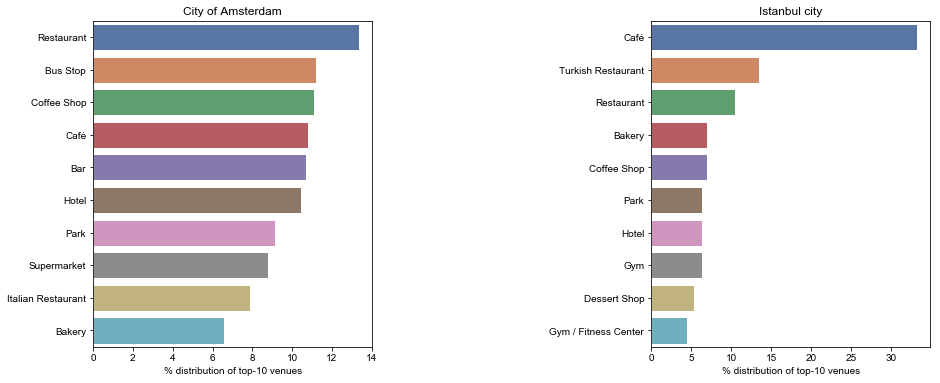

In [55]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,6))
fig.subplots_adjust(wspace=1)
sns.set(style="whitegrid")
sns.barplot(amsterdam_overall_top_10.values, amsterdam_overall_top_10.index, ax=ax1)
ax1.set_xlabel('% distribution of top-10 venues')
ax1.set_title("City of Amsterdam")
sns.barplot(istanbul_overall_top_10.values, istanbul_overall_top_10.index, ax=ax2)
ax2.set_xlabel('% distribution of top-10 venues')
ax2.set_title("Istanbul city")
plt.show()

Now, we will define a function in order to get most common venue categories.

In [161]:
def return_most_common_venue_categories(row, num_top_venues):
    row_categories = row.iloc[2:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    return row_categories_sorted.index.values[0:num_top_venues]

def create_most_common_venue_dataframe(df, top_num):
    indicators = ['st', 'nd', 'rd']

    # create columns according to number of top venues
    column_names = ['District', 'Neighbourhood']
    for ind in np.arange(top_num):
        try:
            column_names.append('{}{} Venue'.format(ind+1, indicators[ind]))
        except:
            column_names.append('{}th Venue'.format(ind+1))

    # create a new dataframe
    df_sorted = pd.DataFrame(columns=column_names)
    df_sorted['District'] = df['District']
    df_sorted['Neighbourhood'] = df['Neighbourhood']

    for ind in np.arange(df.shape[0]):
        df_sorted.iloc[ind, 2:] = return_most_common_venue_categories(df.iloc[ind, :], top_num)
        
    return df_sorted

Now, we will create new dataframes and display the top 30 venues for each city.
First, city of Amsterdam;

In [165]:
amsterdam_most_common = create_most_common_venue_dataframe(amsterdam_venues_grouped, top_num=30)

In [166]:
amsterdam_most_common.head()

,District,Neighbourhood,1st Venue Category,2nd Venue Category,3rd Venue Category,4th Venue Category,5th Venue Category,6th Venue Category,7th Venue Category,8th Venue Category,...,21th Venue Category,22th Venue Category,23th Venue Category,24th Venue Category,25th Venue Category,26th Venue Category,27th Venue Category,28th Venue Category,29th Venue Category,30th Venue Category
0,Centrum,Alexanderplein e.o.,Zoo Exhibit,Restaurant,Café,Supermarket,Theater,Bar,Hotel,Museum,...,Tapas Restaurant,Aquarium,Hookah Bar,Turkish Restaurant,Hostel,African Restaurant,Wine Bar,Park,Zoo,Yoga Studio
1,Centrum,Amstelveldbuurt,Coffee Shop,French Restaurant,Bar,Plaza,Art Museum,Italian Restaurant,Greek Restaurant,Marijuana Dispensary,...,Cheese Shop,Theater,Spa,Spanish Restaurant,Japanese Restaurant,Sandwich Place,Butcher,Hookah Bar,Salad Place,Dessert Shop
2,Centrum,Anjeliersbuurt Noord,Bar,Italian Restaurant,Sandwich Place,Café,Bistro,Spanish Restaurant,Thai Restaurant,Salad Place,...,Pizza Place,Comfort Food Restaurant,Tapas Restaurant,Creperie,Hotel,Indian Restaurant,Yoga Studio,Women's Store,Ice Cream Shop,Indonesian Restaurant
3,Centrum,Anjeliersbuurt Zuid,Bar,Café,Italian Restaurant,Hotel,Sandwich Place,Thai Restaurant,Pizza Place,Bistro,...,Indonesian Restaurant,Food & Drink Shop,Women's Store,Afghan Restaurant,Wine Bar,Historic Site,Hostel,Ice Cream Shop,Art Museum,Indian Restaurant
4,Centrum,BG-terrein e.o.,Hotel,Breakfast Spot,Café,Bar,Marijuana Dispensary,Bookstore,Cocktail Bar,Chinese Restaurant,...,Sandwich Place,Wine Bar,Bakery,Clothing Store,Women's Store,Seafood Restaurant,Thai Restaurant,Italian Restaurant,Cosmetics Shop,Indie Theater


Now, Istanbul city;

In [170]:
istanbul_most_common = create_most_common_venue_dataframe(istanbul_venues_grouped, top_num=30)

In [171]:
istanbul_most_common.head()

,District,Neighbourhood,1st Venue Category,2nd Venue Category,3rd Venue Category,4th Venue Category,5th Venue Category,6th Venue Category,7th Venue Category,8th Venue Category,...,21th Venue Category,22th Venue Category,23th Venue Category,24th Venue Category,25th Venue Category,26th Venue Category,27th Venue Category,28th Venue Category,29th Venue Category,30th Venue Category
0,Adalar,Burgazada,Seafood Restaurant,Café,Beach,Boat or Ferry,Pier,Bakery,Restaurant,Hotel,...,Plaza,History Museum,Ice Cream Shop,Fish & Chips Shop,Duty-free Shop,Eastern European Restaurant,Film Studio,Electronics Store,Farmers Market,Fabric Shop
1,Adalar,Heybeliada,Café,Seafood Restaurant,Turkish Restaurant,Bakery,Fast Food Restaurant,Beach,Bed & Breakfast,Dessert Shop,...,Snack Place,Soccer Stadium,Pool,Hotel,Harbor / Marina,Plaza,Waterfront,History Museum,Historic Site,Duty-free Shop
2,Adalar,Kınalıada,Café,Seafood Restaurant,Beach,Dessert Shop,Breakfast Spot,Ice Cream Shop,Kebab Restaurant,Buffet,...,Mediterranean Restaurant,Shopping Mall,Steakhouse,Pie Shop,Bakery,Soccer Stadium,Greek Restaurant,Hotel,Costume Shop,Cuban Restaurant
3,Adalar,Maden,Hotel,Historic Site,Beach,Café,History Museum,Bed & Breakfast,BBQ Joint,Road,...,Donut Shop,Exhibit,Event Space,Fabric Shop,Factory,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Film Studio
4,Adalar,Nizam,Beach,Harbor / Marina,Bed & Breakfast,Mountain,BBQ Joint,Cafeteria,Breakfast Spot,Hotel,...,Snack Place,Hostel,Event Service,Event Space,Entertainment Service,English Restaurant,Electronics Store,Çöp Şiş Place,Exhibit,Fabric Shop


### Final step of analysis
In this step we will merge our dataframes and we will apply k-means algorithm in order to find similarity.
We should find the best k values by ....

In [172]:
# Before adding dataframes we will add city column
amsterdam_venues_grouped.insert(0, column='City', value="Amsterdam")
istanbul_venues_grouped.insert(0, column='City', value="Istanbul")

In [173]:
all_venues_grouped = amsterdam_venues_grouped.append(istanbul_venues_grouped, sort=False)
all_venues_grouped.shape

(943, 517)

In [174]:
all_venues_grouped.isnull().sum()

City                                 0
District                             0
Neighbourhood                        0
Accessories Store                    0
Advertising Agency                   0
Afghan Restaurant                    0
African Restaurant                   0
American Restaurant                  0
Antique Shop                         0
Aquarium                             0
Arcade                               0
Argentinian Restaurant               0
Art Gallery                          0
Art Museum                           0
Arts & Crafts Store                  0
Arts & Entertainment                 0
Asian Restaurant                     0
Athletics & Sports                   0
Australian Restaurant              521
Austrian Restaurant                  0
Auto Dealership                      0
Auto Garage                          0
Auto Workshop                        0
BBQ Joint                            0
Baby Store                           0
Bagel Shop               

We will fill Nan values with 0.

In [175]:
all_venues_grouped.fillna(value=0, inplace = True)

For determining the optimal number of clusters we will use elbow method. 

In [176]:
X = all_venues_grouped.iloc[:, 3:]

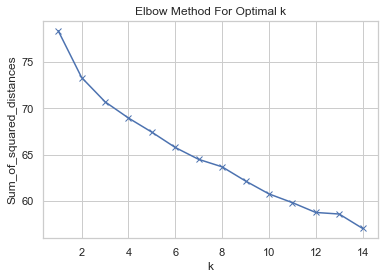

In [177]:
from sklearn.cluster import KMeans

sum_of_squared_distances = []
kRange = range(1, 15)

for k in kRange:
    kmeans = KMeans(n_clusters=k, random_state=0).fit(X)
    sum_of_squared_distances.append(kmeans.inertia_)
    
plt.plot(kRange, sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

The most significant bend is at 12. That's why we choose k as 12.

In [209]:
k = 12
kmeans = KMeans(n_clusters=k, random_state=0).fit(X)

In [210]:
kmeans.labels_.shape

(943,)

In [211]:
all_venues_grouped.insert(3, column='Cluster_Labels', value=kmeans.labels_)
all_venues_grouped.head()

,City,District,Neighbourhood,Cluster_Labels,Accessories Store,Advertising Agency,Afghan Restaurant,African Restaurant,American Restaurant,Antique Shop,...,Video Store,Volleyball Court,Warehouse Store,Watch Shop,Water Park,Waterfront,Wedding Hall,Winery,Wings Joint,Çöp Şiş Place
0,Amsterdam,Centrum,Alexanderplein e.o.,6,0.0,0.0,0.00,0.02,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Amsterdam,Centrum,Amstelveldbuurt,6,0.0,0.0,0.00,0.00,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Amsterdam,Centrum,Anjeliersbuurt Noord,6,0.0,0.0,0.00,0.00,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Amsterdam,Centrum,Anjeliersbuurt Zuid,6,0.0,0.0,0.02,0.00,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Amsterdam,Centrum,BG-terrein e.o.,6,0.0,0.0,0.00,0.00,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Now we will divide this datasets and insert the label into orginal datasets and after that we will visualize clusters on the map.

In [212]:
amsterdam_clusters = all_venues_grouped.loc[all_venues_grouped.City == "Amsterdam", ['District', 'Neighbourhood', 'Cluster_Labels']]
istanbul_clusters = all_venues_grouped.loc[all_venues_grouped.City == "Istanbul", ['District', 'Neighbourhood', 'Cluster_Labels']]

In [213]:
amsterdam_most_common_clustered = pd.merge(amsterdam_clusters, amsterdam_most_common, on=['District', 'Neighbourhood'], how='left')
amsterdam_merged = pd.merge(amsterdam_df, amsterdam_most_common_clustered, on=['District', 'Neighbourhood'], how='left')
amsterdam_merged.head()

,District,Neighbourhood,Latitude,Longitude,Cluster_Labels,1st Venue Category,2nd Venue Category,3rd Venue Category,4th Venue Category,5th Venue Category,...,21th Venue Category,22th Venue Category,23th Venue Category,24th Venue Category,25th Venue Category,26th Venue Category,27th Venue Category,28th Venue Category,29th Venue Category,30th Venue Category
0,Nieuw-West,Calandlaan/Lelylaan,52.355708,4.809697,4,Shopping Mall,Bus Stop,Theater,Drugstore,Gym,...,Farmers Market,Fast Food Restaurant,Fish Market,Fish & Chips Shop,Falafel Restaurant,Eastern European Restaurant,Farm,Fabric Shop,Zoo Exhibit,Dutch Restaurant
1,Nieuw-West,Osdorp Zuidoost,52.353736,4.811344,4,Flower Shop,Bus Stop,Gym / Fitness Center,Indonesian Restaurant,Turkish Restaurant,...,Food,Food & Drink Shop,Food Court,Electronics Store,Dumpling Restaurant,Dutch Restaurant,Food Stand,Creperie,Cruise,Cupcake Shop
2,Nieuw-West,Osdorp Midden Noord,52.362078,4.791792,4,Bakery,Supermarket,Hotel,Italian Restaurant,Hobby Shop,...,Flower Shop,Fondue Restaurant,Food,Food & Drink Shop,Fast Food Restaurant,Dutch Restaurant,Food Service,Dumpling Restaurant,Creperie,Cruise
3,Nieuw-West,Osdorp Midden Zuid,52.358838,4.793781,4,Supermarket,Turkish Restaurant,Italian Restaurant,Pharmacy,Dessert Shop,...,Falafel Restaurant,Farm,Farmers Market,Eastern European Restaurant,Fast Food Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Electronics Store,Doner Restaurant
4,Nieuw-West,Zuidwestkwadrant Osdorp Noord,52.355523,4.795597,4,Supermarket,Turkish Restaurant,Mediterranean Restaurant,BBQ Joint,Park,...,Fish & Chips Shop,Ethiopian Restaurant,Fish Market,Flea Market,Flower Shop,Fondue Restaurant,Event Space,Dutch Restaurant,Empanada Restaurant,Discount Store


In [214]:
istanbul_most_common_clustered = pd.merge(istanbul_clusters, istanbul_most_common, on=['District', 'Neighbourhood'], how='left')
istanbul_merged = pd.merge(istanbul_df, istanbul_most_common_clustered, on=['District', 'Neighbourhood'], how='left')
istanbul_merged.head()

,District,Neighbourhood,Latitude,Longitude,Cluster_Labels,1st Venue Category,2nd Venue Category,3rd Venue Category,4th Venue Category,5th Venue Category,...,21th Venue Category,22th Venue Category,23th Venue Category,24th Venue Category,25th Venue Category,26th Venue Category,27th Venue Category,28th Venue Category,29th Venue Category,30th Venue Category
0,Adalar,Burgazada,40.880000,29.066944,2,Seafood Restaurant,Café,Beach,Boat or Ferry,Pier,...,Plaza,History Museum,Ice Cream Shop,Fish & Chips Shop,Duty-free Shop,Eastern European Restaurant,Film Studio,Electronics Store,Farmers Market,Fabric Shop
1,Adalar,Heybeliada,40.877974,29.095299,2,Café,Seafood Restaurant,Turkish Restaurant,Bakery,Fast Food Restaurant,...,Snack Place,Soccer Stadium,Pool,Hotel,Harbor / Marina,Plaza,Waterfront,History Museum,Historic Site,Duty-free Shop
2,Adalar,Kınalıada,40.909070,29.053205,3,Café,Seafood Restaurant,Beach,Dessert Shop,Breakfast Spot,...,Mediterranean Restaurant,Shopping Mall,Steakhouse,Pie Shop,Bakery,Soccer Stadium,Greek Restaurant,Hotel,Costume Shop,Cuban Restaurant
3,Adalar,Maden,40.858320,29.123072,0,Hotel,Historic Site,Beach,Café,History Museum,...,Donut Shop,Exhibit,Event Space,Fabric Shop,Factory,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Film Studio
4,Adalar,Nizam,40.863169,29.116381,6,Beach,Harbor / Marina,Bed & Breakfast,Mountain,BBQ Joint,...,Snack Place,Hostel,Event Service,Event Space,Entertainment Service,English Restaurant,Electronics Store,Çöp Şiş Place,Exhibit,Fabric Shop


### Visualization of clusters

In [312]:
# set color scheme for the clusters
x = np.arange(k)
ys = [i + x + (i*x)**2 for i in range(k)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

def show_clusters(df, lat, long, z_start):
    map_clusters = folium.Map(location=[lat, long], zoom_start=z_start)

    for lat, lon, neigh, dist, cluster in zip(df['Latitude'], df['Longitude'], df['Neighbourhood'], df['District'], df['Cluster_Labels']):
        lbl = '{}, {}, Cluster {}'.format(neigh, dist, cluster)
        label = folium.Popup(lbl, parse_html=True)
        folium.CircleMarker(
            [lat, lon],
            radius=5,
            popup=label,
            color=rainbow[cluster-1],
            fill=True,
            fill_color=rainbow[cluster-1],
            fill_opacity=0.7).add_to(map_clusters)

    return map_clusters

In [216]:
show_clusters(amsterdam_merged, lat_amsterdam, long_amsterdam, 12)

In [217]:
show_clusters(istanbul_merged, lat_istanbul, long_istanbul, 12)

In [226]:
cluster_0 = amsterdam_merged.loc[amsterdam_merged.Cluster_Labels==0]
cluster_0.shape

(38, 35)

In [344]:
def how_many_turkish(venue_list):
    turkish_words = ['Borek', 'Cigkofte', 'Doner', 'Gozleme', 'Kofte', 'Kokoreç', 'Kumpir', 'Kumru', 
                     'Manti', 'Meyhane', 'Pide', 'Pilavcı', 'Söğüş', 'Tantuni', 'Turkish', 'Çöp Şiş']
    turkish = False
    cnt = 0
    for r in turkish_words:
        for venue in venue_list:
            if r in venue:
                cnt += 1
                turkish = True
            else:
                turkish = False
    return cnt

def analyze_turkish(df_to_analyze):
    df = df_to_analyze.reset_index(drop=True).T
    for column in df.columns.values:
        try:
            df.loc['Turkish_count', column] = how_many_turkish(df.iloc[5:35, column])
        except:
            print(column)
    return df.T

In [345]:
def show_analised(df, lat, long, z_start):
    map_clusters = folium.Map(location=[lat, long], zoom_start=z_start)
    
    df = df.loc[df.Turkish_count > 0]
    for lat, lon, neigh, dist, cluster, turkish in zip(df['Latitude'], df['Longitude'], df['Neighbourhood'], 
                                                       df['District'], df['Cluster_Labels'], df['Turkish_count']):
            lbl = '{}, {}, count {}'.format(neigh, dist, turkish)
            label = folium.Popup(lbl, parse_html=True)
            folium.CircleMarker(
                [lat, lon],
                radius=5,
                popup=label,
                color=rainbow[turkish-1],
                fill=True,
                fill_color=rainbow[turkish-1],
                fill_opacity=0.7).add_to(map_clusters)

    return map_clusters

In [342]:
cluster_0_analised = analyze_turkish(amsterdam_merged.loc[amsterdam_merged.Cluster_Labels==0])
cluster_0_analised.loc[cluster_0_analised.Turkish_count > 0]

,District,Neighbourhood,Latitude,Longitude,Cluster_Labels,1st Venue Category,2nd Venue Category,3rd Venue Category,4th Venue Category,5th Venue Category,...,22th Venue Category,23th Venue Category,24th Venue Category,25th Venue Category,26th Venue Category,27th Venue Category,28th Venue Category,29th Venue Category,30th Venue Category,Turkish_count
2,Nieuw-West,Lucas/Andreasziekenhuis e.o.,52.3712,4.8387,0,Gym / Fitness Center,Restaurant,Hotel,Nightclub,Tennis Court,...,Farmers Market,Ethiopian Restaurant,Event Space,Dumpling Restaurant,Exhibit,Fabric Shop,Dutch Restaurant,Doner Restaurant,Drugstore,1
4,Nieuw-West,Andreasterrein,52.355,4.84572,0,Hotel,Coffee Shop,Snack Place,Middle Eastern Restaurant,Café,...,Deli / Bodega,Dance Studio,Farm,Farmers Market,Fast Food Restaurant,Fish & Chips Shop,Event Space,Fish Market,Flea Market,1
25,Zuid,Kop Zuidas,52.3377,4.89464,0,Hotel,Gym / Fitness Center,Plaza,Antique Shop,Seafood Restaurant,...,Fast Food Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Eastern European Restaurant,Doner Restaurant,Dumpling Restaurant,Department Store,1
30,Nieuw-West,Teleport,52.3901,4.83204,0,Hotel,Train Station,Gastropub,Platform,Coffee Shop,...,Movie Theater,Concert Hall,Convenience Store,Pizza Place,Exhibit,Falafel Restaurant,Event Space,Farm,Ethiopian Restaurant,1


In [343]:
show_clusters(cluster_0, lat_amsterdam, long_amsterdam, 11)

In [341]:
show_analised(cluster_0_analised, lat_amsterdam, long_amsterdam, 11)